In [2]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torchsummary import summary
from torch import Tensor
from torch import nn
from torchvision.transforms import InterpolationMode

# utils for image processing and display
import matplotlib.pyplot as plt
import numpy as np
import time
from PIL import ImageOps, ImageFilter 


# Warnings
import warnings 
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", module = "matplotlib\..")

# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [17]:
batchsize = 128
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

trainset = torchvision.datasets.CIFAR10(root='./data', train = True,
                                        download = True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = batchsize,
                                          shuffle = True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train = False,
                                        download = True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = batchsize,
                                          shuffle = False, num_workers=2)

classes = ('plane','car','bird','cat',
           'deer','dog','frog','horse','ship','truck')

Files already downloaded and verified
Files already downloaded and verified


 frog plane truck   cat


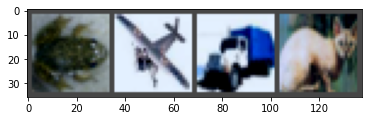

In [18]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  npimg = npimg/np.amax(npimg)
  npimg = np.clip(npimg, 0, 1)
  plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Show Images
imshow(torchvision.utils.make_grid(images[:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [19]:
#building the basic block that constitutes all Resnet models
class BasicBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1, downsample=None):
    super(BasicBlock, self).__init__()
    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1, bias = False)
    self.bn1 = nn.BatchNorm2d(out_channels)
    self.relu = nn.ReLU(inplace=True)
    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1,bias = False)
    self.bn2 = nn.BatchNorm2d(out_channels)
    self.downsample = downsample

  def forward(self, x):
    identity = x
    out = self.conv1(x)
    out = self.bn1(out)
    out = self.relu(out)
    out = self.conv2(out)
    out = self.bn2(out)


    if self.downsample is not None:
      identity = self.downsample(x)

    out += identity
    out = self.relu(out)
    return out    

#class needed for modifying the forward pass on occasion
class LambdaLayer(nn.Module):
  def __init__(self, lambd):
    super(LambdaLayer, self).__init__()
    self.lambd = lambd


  def forward(self, x):
    return self.lambd(x)  

In [20]:
#defining the whole Resnet as a sequence of basic balock
class ResNet_CIFAR(nn.Module):

  def __init__(self, block, img_channels = 3, num_layers = 18, num_classes = 10):
    super(ResNet_CIFAR, self).__init__()
    layers = [2,2,2]                          #architecture of resnet 18
    self.in_channels = 16

    #Resnet
    self.conv1 = nn.Conv2d(in_channels=img_channels, out_channels = self.in_channels, kernel_size=3,
                           stride=1, padding=1, bias = False)
    self.bn1 = nn.BatchNorm2d(self.in_channels)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride=2, padding=1)

    # Basic blocks
    self.layer1 = self._make_layer(block, 16, layers[0])
   
    self.layer2 = self._make_layer(block, 32, layers[1], stride = 2)
    
    self.layer3 = self._make_layer(block, 64, layers[2], stride = 2)
   
    #self.layer4 = self._make_layer(block, 128, layers[3], stride = 2)

    #classifier head
    self.avgpool = nn.AdaptiveAvgPool2d((1,1))
    self.fc = nn.Linear(64, num_classes)
    #self.sm = nn.Softmax()     # will include this in loss fn


  def _make_layer(self, block, out_channels, blocks, stride = 1) -> nn.Sequential:
    downsample = None
    # When the sride is more than one, the residual input has to be scaled down in order to aviod dimensional incompatibility
    if stride != 1:
      downsample = LambdaLayer(lambda x:
                        F.pad(x[:,:, ::2, ::2], (0, 0, 0, 0, out_channels//4, out_channels//4), "constant", 0))
        
    layers = []
    layers.append(
      block(self.in_channels, out_channels, stride, downsample)
      )
    self.in_channels = out_channels

    for i in range(1,blocks):
      layers.append(
        block(self.in_channels, out_channels)
        )
    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    #x = self.maxpool(x) not used because CIFAR10 is already low dimensional   

    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)



    x = self.avgpool(x)
    x = torch.flatten(x,1)
    x = self.fc(x) 

    return x
 



   


In [21]:
#instantiation of the ResNet_CIFAR class
model = ResNet_CIFAR(block = BasicBlock, img_channels = 3, num_layers=18, num_classes = 10)
model = model.cuda()
print(model)


ResNet_CIFAR(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

In [22]:
num_epochs = 80          # chosen from original RESNET article
learning_rate = 0.001
torch.manual_seed(5)  #reproduciabitity

model = ResNet_CIFAR(block=BasicBlock, img_channels=3, num_layers = 18, num_classes = 10).to(device)
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [23]:
start = time.time()

losses =  []

model.train()

for epoch in range(num_epochs):

  loss_vals = []

  for i, (images, labels) in enumerate(trainloader):
    images = images.to(device)
    labels = labels.to(device)

    
    # Forward Pass
    outputs = model(images)
    loss_val = loss(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()


    loss_vals.append(loss_val.item())
  print("Epoch ", epoch, "loss:", sum(loss_vals)/len(trainloader))
  losses.append(sum(loss_vals)/len(trainloader))


print("Time to train the model:", round((time.time()-start)/60,2), "minutes")  

Epoch  0 loss: 1.3419836634565192
Epoch  1 loss: 0.9312970342538546
Epoch  2 loss: 0.7667284688681287
Epoch  3 loss: 0.6578169615219926
Epoch  4 loss: 0.581026536957992
Epoch  5 loss: 0.5228462988305884
Epoch  6 loss: 0.4718222807892753
Epoch  7 loss: 0.43301538700033027
Epoch  8 loss: 0.39052709616968395
Epoch  9 loss: 0.3628353505488247
Epoch  10 loss: 0.32118759210914605
Epoch  11 loss: 0.2950199799007162
Epoch  12 loss: 0.26517604445786125
Epoch  13 loss: 0.23466598111040451
Epoch  14 loss: 0.20928367823743455
Epoch  15 loss: 0.1924877080237469
Epoch  16 loss: 0.16815421981808473
Epoch  17 loss: 0.14763954494272352
Epoch  18 loss: 0.13838772216568823
Epoch  19 loss: 0.11778661986941572
Epoch  20 loss: 0.11462279509209916
Epoch  21 loss: 0.1015949332824601
Epoch  22 loss: 0.10022063611451622
Epoch  23 loss: 0.08752679647615803
Epoch  24 loss: 0.08034358512314842
Epoch  25 loss: 0.07994835511269167
Epoch  26 loss: 0.07269977303245641
Epoch  27 loss: 0.06951747354729783
Epoch  28 loss

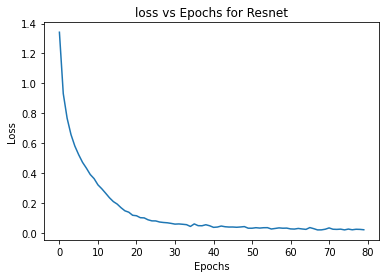

In [24]:
#plots
plt.plot(range(num_epochs),losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("loss vs Epochs for Resnet")
plt.show()

In [25]:
#Testing the model
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in trainloader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy on train images: {} %'.format(100*correct / total)  )

Accuracy on train images: 99.252 %


In [26]:
#Testing the model on testing dataset
model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print('Accuracy on train images: {} %'.format(100*correct / total)  )

Accuracy on train images: 79.89 %


In [27]:
### VICREG

In [28]:
class TrainTransform(object):
  def __init__(self):

    self.transform = transforms.Compose(
        [transforms.RandomResizedCrop(32, scale=(0.4,0.9), interpolation=InterpolationMode.BICUBIC),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],p=0.8,),
         transforms.RandomGrayscale(p=0.2),
         #GaussianBlur(p=1.0),
         Solarization(p=0.0),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

    self.transform_prime = transforms.Compose(
        [transforms.RandomResizedCrop(32, scale=(0.4,0.9), interpolation=InterpolationMode.BICUBIC),
         transforms.RandomHorizontalFlip(p=0.5),
         transforms.RandomApply([transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],p=0.8,),
         transforms.RandomGrayscale(p=0.2),
         #GaussianBlur(p=1.0),
         Solarization(p=0.0),
         transforms.ToTensor(),
         transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


  def __call__(self,sample):
    x1 = self.transform(sample)
    x2 = self.transform_prime(sample)
    return x1, x2

class GaussianBlur(object):
  def __init__(self, p):
    self.p = p

  def __call__(self, img):
    if np.random.rand() < self.p:
      sigma = np.random.rand()*1.9 + 0.1
      return img.filter(ImageFilter.GaussianBlur(sigma))
    else:
      return img

class Solarization(object):
  def __init__(self, p):
    self.p = p


  def __call__(self, img):  
    if np.random.rand() < self.p:
      return ImageOps.solarize(img)
    else:
      return img


In [29]:
batchsize = 128
transform = TrainTransform()

trainset_siamese = torchvision.datasets.CIFAR10(root='/data', train = True,
                                        download = True, transform=transform)

trainloader_siamese = torch.utils.data.DataLoader(trainset_siamese, batch_size=batchsize,
                                        shuffle=True, num_workers=2)

testset_siamese = torchvision.datasets.CIFAR10(root='/data', train = False,
                                        download = True, transform=transform)

testloader_siamese = torch.utils.data.DataLoader(trainset_siamese, batch_size=batchsize,
                                      shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:13<00:00, 12874055.14it/s]


Extracting /data/cifar-10-python.tar.gz to /data
Files already downloaded and verified


 frog   car  bird plane


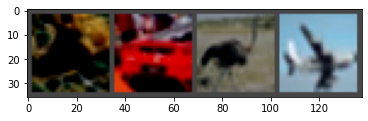

In [30]:
#functions to show image

dataiter = iter(trainloader_siamese)
images, labels = next(dataiter)

#show first crop of the input image + random transform

imshow(torchvision.utils.make_grid(images[0][0:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

 frog   car  bird plane


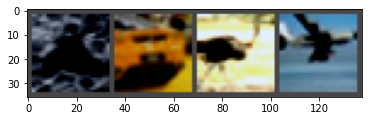

In [31]:
#show second crop of the input image + random transform

imshow(torchvision.utils.make_grid(images[1][0:4]))
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [32]:
#projector builder function for VICReg global loss

def Projector(embedding, dimension):
  return nn.Sequential(
      nn.Linear(embedding, dimension),
      nn.ReLU(True),
      nn.Linear(dimension, dimension),
      nn.BatchNorm1d(dimension),
      nn.ReLU(True),
      nn.Linear(dimension, dimension, bias = False)
  )

#useful later during loss calculation
def off_diagonal(x):
  n, m = x.shape
  assert n == m
  return x.flatten()[:-1].view(n-1, n+1)[:, 1:].flatten()



In [36]:
class VICReg(nn.Module):

  def __init__(self,batchsize):
    super(VICReg, self).__init__()
    self.batchsize = batchsize
    self.embedding = 64
    self.num_features = 256
    self.backbone = ResNet_CIFAR(block = BasicBlock, img_channels = 3, num_layers = 18, num_classes = 10)
    self.backbone.fc = nn.Identity()
    self.projector = Projector(self.embedding, self.num_features)


  def forward(self, x, y):
    x = self.projector(self.backbone(x))
    y = self.projector(self.backbone(y))

    repr_loss = F.mse_loss(x,y)

    x = x-x.mean(dim = 0)
    y = y-y.mean(dim = 0)


    std_x = torch.sqrt(x.var(dim=0) + 0.0001)
    std_y = torch.sqrt(y.var(dim=0) + 0.0001)


    std_loss = torch.mean(F.relu(1-std_x))/2 + torch.mean(F.relu(1 - std_y))/2

    cov_x = (torch.matmul(x.T, x))/(self.batchsize - 1)
    cov_y = (torch.matmul(y.T, y))/(self.batchsize - 1)

    cov_loss = off_diagonal(cov_x).pow_(2).sum().div(self.num_features) + off_diagonal(cov_y).pow_(2).sum().div(self.num_features)

    loss = (25*repr_loss + 25*std_loss + 1*cov_loss)

    return loss


In [37]:
start = time.time()

torch.manual_seed(5)
torch.backends.cudnn.benchmark = True #this checks  multiple convolution algorithms at the start of running and takes


#initialize model
model = VICReg(batchsize)
model.to(device) #may get errors if the type of tensor isn't suitable for the cuda architecture
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate) #we chose Adam for simplicity

losses=[]

for epoch in range(num_epochs):

    loss_vals = []

    for i, ((x,y), labels) in enumerate(trainloader_siamese):
        x = x.to(device)
        y = y.to(device)

        loss = model.forward(x,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_vals.append(loss.item())
    print("Epoch", epoch, "Total Loss:", sum(loss_vals)/len(trainloader_siamese))
    losses.append(sum(loss_vals)/len(trainloader_siamese))

print("Time to train model:", round((time.time() - start) / 60,2), "minutes")

Epoch 0 Total Loss: 17.81484826324541
Epoch 1 Total Loss: 16.31066867701538
Epoch 2 Total Loss: 15.701273727904805
Epoch 3 Total Loss: 15.227861831255277
Epoch 4 Total Loss: 14.896668482924362
Epoch 5 Total Loss: 14.62859109844393
Epoch 6 Total Loss: 14.377062297538114
Epoch 7 Total Loss: 14.186181541598971
Epoch 8 Total Loss: 14.018976209108788
Epoch 9 Total Loss: 13.840131254757152
Epoch 10 Total Loss: 13.679559856424552
Epoch 11 Total Loss: 13.584790129795708
Epoch 12 Total Loss: 13.45605781682007
Epoch 13 Total Loss: 13.365483086432338
Epoch 14 Total Loss: 13.222639583870578
Epoch 15 Total Loss: 13.141010250276922
Epoch 16 Total Loss: 13.058009391550518
Epoch 17 Total Loss: 12.981661220950544
Epoch 18 Total Loss: 12.920795350428433
Epoch 19 Total Loss: 12.824986674901469
Epoch 20 Total Loss: 12.763829609317243
Epoch 21 Total Loss: 12.711791099489803
Epoch 22 Total Loss: 12.654499363716301
Epoch 23 Total Loss: 12.587954187027329
Epoch 24 Total Loss: 12.53553638311908
Epoch 25 Total 

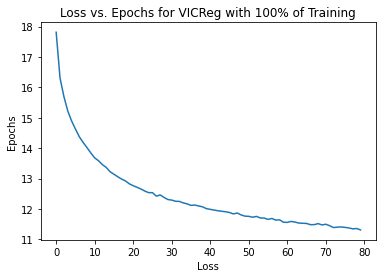

In [38]:
#plot the average loss over time
plt.plot(range(num_epochs), losses)
plt.ylabel("Epochs")
plt.xlabel("Loss")
plt.title("Loss vs. Epochs for VICReg with 100% of Training")
plt.show()

In [39]:
#save the model

torch.save(model.state_dict(), 'model_vicreg_100')

In [42]:
#VICReg Loading

#initialize an instance of model in order to load its trained parameters from drive
model = VICReg(batchsize)
model.load_state_dict(torch.load('model_vicreg_100'))

#isolate the pretrained backbone
model = model.backbone

#freeze all base layers
for param in model.parameters():
  param.requires_grad = False

#add a dense layer
model.fc = nn.Linear(64, 10)

#add model to device
model.to(device)

#summary of the model
summary(model, input_size = (3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [44]:
start = time.time()
torch.manual_seed(5)

#define loss and optimizer

learning_rate = 0.001
num_epochs = 80
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()


losses = []
model.train()

for epoch in range(num_epochs):

  loss_vals = []

  for i, (images, labels) in enumerate(trainloader):
    images = images.to(device)
    labels = labels.to(device)

    #Forward pass
    outputs = model(images)
    loss_val = loss(outputs, labels)

    #Backward and optimize
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    loss_vals.append(loss_val.item())


  print("Epoch", epoch, "Loss:", sum(loss_vals)/len(trainloader))
  losses.append(sum(loss_vals)/len(trainloader))

print("Time to train model:", round((time.time() - start)/60,2), "minutes")


Epoch 0 Loss: 1.5689096316657103
Epoch 1 Loss: 1.1098962865217263
Epoch 2 Loss: 0.9988231337283884
Epoch 3 Loss: 0.9480822243349022
Epoch 4 Loss: 0.9180480171652401
Epoch 5 Loss: 0.8985937022796983
Epoch 6 Loss: 0.8850691664554274
Epoch 7 Loss: 0.87356786227897
Epoch 8 Loss: 0.8656576803273253
Epoch 9 Loss: 0.8587356252438577
Epoch 10 Loss: 0.8518397494045364
Epoch 11 Loss: 0.8481788720621173
Epoch 12 Loss: 0.8446264449897629
Epoch 13 Loss: 0.8402719351336779
Epoch 14 Loss: 0.8385197832761213
Epoch 15 Loss: 0.8348249329630372
Epoch 16 Loss: 0.832877278632825
Epoch 17 Loss: 0.8292687113022865
Epoch 18 Loss: 0.8289916779074218
Epoch 19 Loss: 0.8262403618039378
Epoch 20 Loss: 0.8235666524723667
Epoch 21 Loss: 0.8234470171086928
Epoch 22 Loss: 0.8203852504415585
Epoch 23 Loss: 0.8198868697866455
Epoch 24 Loss: 0.8191674929445661
Epoch 25 Loss: 0.817736052491171
Epoch 26 Loss: 0.8166006850769453
Epoch 27 Loss: 0.8141933388417334
Epoch 28 Loss: 0.8143076901240727
Epoch 29 Loss: 0.81351522716

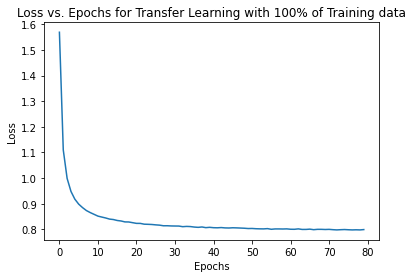

In [46]:
#plotting the average loss over time

plt.plot(range(num_epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss vs. Epochs for Transfer Learning with 100% of Training data")
plt.show()

In [48]:
#Training set accuracy of the model

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in trainloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print("Accuracy of the model on the train images: {} %".format(100*correct/total))


Accuracy of the model on the train images: 72.028 %


In [50]:
#Test set accuracy of the model

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print("Accuracy of the model on the test images: {} %".format(100*correct/total))


Accuracy of the model on the test images: 71.66 %


In [ ]:
### exp 2

In [52]:
from torch.utils.data import random_split
batchsize = 128
transform = TrainTransform()

trainset_siamese = torchvision.datasets.CIFAR10(root='/data', train = True,
                                        download = True, transform=transform)

#trainloader_siamese = torch.utils.data.DataLoader(trainset_siamese, batch_size=batchsize,
                                 #       shuffle=True, num_workers=2)

 #Define the sizes for 80 / 20
total_size = len(trainset_siamese)
train_size = int(0.8 * total_size)
val_size = total_size - train_size


train_80, train_20 = random_split(trainset_siamese, [train_size, val_size])



trainloader_80 = torch.utils.data.DataLoader(train_80, batch_size=batchsize,
                                        shuffle=True, num_workers=2)
trainloader_20 = torch.utils.data.DataLoader(train_20, batch_size=batchsize,
                                        shuffle=True, num_workers=2)

testset_siamese = torchvision.datasets.CIFAR10(root='/data', train = False,
                                        download = True, transform=transform)

testloader_siamese = torch.utils.data.DataLoader(trainset_siamese, batch_size=batchsize,
                                      shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')










Files already downloaded and verified
Files already downloaded and verified


In [53]:
start = time.time()

torch.manual_seed(5)
torch.backends.cudnn.benchmark = True #this checks  multiple convolution algorithms at the start of running and takes


#initialize model
model = VICReg(batchsize)
model.to(device) #may get errors if the type of tensor isn't suitable for the cuda architecture
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate) #we chose Adam for simplicity

losses=[]

for epoch in range(num_epochs):

    loss_vals = []

    for i, ((x,y), labels) in enumerate(trainloader_80):
        x = x.to(device)
        y = y.to(device)

        loss = model.forward(x,y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_vals.append(loss.item())
    print("Epoch", epoch, "Total Loss:", sum(loss_vals)/len(trainloader_siamese))
    losses.append(sum(loss_vals)/len(trainloader_siamese))

print("Time to train model:", round((time.time() - start) / 60,2), "minutes")

Epoch 0 Total Loss: 14.532393996977746
Epoch 1 Total Loss: 13.316713825820962
Epoch 2 Total Loss: 12.771824926976352
Epoch 3 Total Loss: 12.41805357091567
Epoch 4 Total Loss: 12.153398394279773
Epoch 5 Total Loss: 11.937371280796997
Epoch 6 Total Loss: 11.72974226724766
Epoch 7 Total Loss: 11.55437512166055
Epoch 8 Total Loss: 11.433952590083832
Epoch 9 Total Loss: 11.294469174826542
Epoch 10 Total Loss: 11.205614299725388
Epoch 11 Total Loss: 11.065382167201518
Epoch 12 Total Loss: 10.974221705170848
Epoch 13 Total Loss: 10.896950321734105
Epoch 14 Total Loss: 10.817154891655573
Epoch 15 Total Loss: 10.772804545624481
Epoch 16 Total Loss: 10.697708310373605
Epoch 17 Total Loss: 10.623210397217889
Epoch 18 Total Loss: 10.558346006876368
Epoch 19 Total Loss: 10.512434252082844
Epoch 20 Total Loss: 10.489043562613485
Epoch 21 Total Loss: 10.405929143471486
Epoch 22 Total Loss: 10.390746687379334
Epoch 23 Total Loss: 10.319035866681267
Epoch 24 Total Loss: 10.298283435499577
Epoch 25 Tota

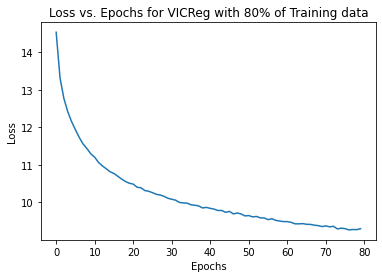

In [55]:
#plotting the average loss over time

plt.plot(range(num_epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss vs. Epochs for VICReg with 80% of Training data")
plt.show()

In [56]:
#save the model

torch.save(model.state_dict(), 'model_vicreg_80')

In [57]:
#VICReg Loading

#initialize an instance of model in order to load its trained parameters from drive
model = VICReg(batchsize)
model.load_state_dict(torch.load('model_vicreg_80'))

#isolate the pretrained backbone
model = model.backbone

#freeze all base layers
for param in model.parameters():
  param.requires_grad = False

#add a dense layer
model.fc = nn.Linear(64, 10)

#add model to device
model.to(device)

#summary of the model
summary(model, input_size = (3,32,32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 16, 32, 32]           2,304
       BatchNorm2d-5           [-1, 16, 32, 32]              32
              ReLU-6           [-1, 16, 32, 32]               0
            Conv2d-7           [-1, 16, 32, 32]           2,304
       BatchNorm2d-8           [-1, 16, 32, 32]              32
              ReLU-9           [-1, 16, 32, 32]               0
       BasicBlock-10           [-1, 16, 32, 32]               0
           Conv2d-11           [-1, 16, 32, 32]           2,304
      BatchNorm2d-12           [-1, 16, 32, 32]              32
             ReLU-13           [-1, 16, 32, 32]               0
           Conv2d-14           [-1, 16,

In [60]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


trainset_siamese = torchvision.datasets.CIFAR10(root='/data', train = True,
                                        download = True, transform=transform)

#trainloader_siamese = torch.utils.data.DataLoader(trainset_siamese, batch_size=batchsize,
                                 #       shuffle=True, num_workers=2)

 #Define the sizes for 80 / 20
total_size = len(trainset_siamese)
train_size = int(0.8 * total_size)
val_size = total_size - train_size


train_80, train_20 = random_split(trainset_siamese, [train_size, val_size])



trainloader_80 = torch.utils.data.DataLoader(train_80, batch_size=batchsize,
                                        shuffle=True, num_workers=2)
trainloader_20 = torch.utils.data.DataLoader(train_20, batch_size=batchsize,
                                        shuffle=True, num_workers=2)

testset_siamese = torchvision.datasets.CIFAR10(root='/data', train = False,
                                        download = True, transform=transform)

testloader_siamese = torch.utils.data.DataLoader(trainset_siamese, batch_size=batchsize,
                                      shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [61]:
start = time.time()
torch.manual_seed(5)

#define loss and optimizer

learning_rate = 0.001
num_epochs = 80
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
loss = nn.CrossEntropyLoss()


losses = []
model.train()

for epoch in range(num_epochs):

  loss_vals = []

  for i, (images, labels) in enumerate(trainloader_20):
    images = images.to(device)
    labels = labels.to(device)

    #Forward pass
    outputs = model(images)
    loss_val = loss(outputs, labels)

    #Backward and optimize
    optimizer.zero_grad()
    loss_val.backward()
    optimizer.step()

    loss_vals.append(loss_val.item())


  print("Epoch", epoch, "Loss:", sum(loss_vals)/len(trainloader_20))
  losses.append(sum(loss_vals)/len(trainloader_20))

print("Time to train model:", round((time.time() - start)/60,2), "minutes")


Epoch 0 Loss: 2.1110630744620216
Epoch 1 Loss: 1.7148700952529907
Epoch 2 Loss: 1.4797562843636622
Epoch 3 Loss: 1.3407875088196766
Epoch 4 Loss: 1.2435188972497289
Epoch 5 Loss: 1.181741934788378
Epoch 6 Loss: 1.1316303610801697
Epoch 7 Loss: 1.0954923841017712
Epoch 8 Loss: 1.0704980017263679
Epoch 9 Loss: 1.0435321217850795
Epoch 10 Loss: 1.0264175745505322
Epoch 11 Loss: 1.0081918888454195
Epoch 12 Loss: 0.9959233041051068
Epoch 13 Loss: 0.9847065964831582
Epoch 14 Loss: 0.9696342635758316
Epoch 15 Loss: 0.9611517522908464
Epoch 16 Loss: 0.9532229794731623
Epoch 17 Loss: 0.9434708847275263
Epoch 18 Loss: 0.9392305446576469
Epoch 19 Loss: 0.9302260015584245
Epoch 20 Loss: 0.9223358261434338
Epoch 21 Loss: 0.9214782684664183
Epoch 22 Loss: 0.9129020051111149
Epoch 23 Loss: 0.9155316564101207
Epoch 24 Loss: 0.9069811369799361
Epoch 25 Loss: 0.8987472208240365
Epoch 26 Loss: 0.8996098448958578
Epoch 27 Loss: 0.900516334213788
Epoch 28 Loss: 0.8961192180838766
Epoch 29 Loss: 0.885570363

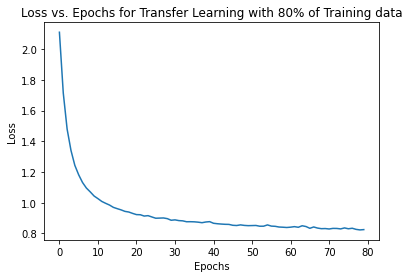

In [63]:
#plotting the average loss over time

plt.plot(range(num_epochs), losses)
plt.ylabel("Loss")
plt.xlabel("Epochs")
plt.title("Loss vs. Epochs for Transfer Learning with 80% of Training data")
plt.show()

In [65]:
#Train set accuracy

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in trainloader_20:
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print("Accuracy of the model on the train images: {} %".format(100*correct/total))

Accuracy of the model on the train images: 70.59 %


In [66]:
#Test set accuracy of the model

model.eval()
with torch.no_grad():
  correct = 0
  total = 0
  for images, labels in testloader_siamese :
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()

  print("Accuracy of the model on the test images: {} %".format(100*correct/total))


Accuracy of the model on the test images: 70.476 %
